<h1>
Behavior classification starter kit 🐁🐀
</h1>
This code is adapted from a notebook created by Dipam Chakraborty at AIcrowd for the <a href=https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications>Multi-Agent Behavior Challenge</a>.


# Import necessary modules and packages 📚


In [1]:
import os
import json
import numpy as np
import pandas as pd

# Download the dataset 📲

The CalMS21 dataset is hosted by [Caltech](https://data.caltech.edu/records/1991). For now, we'll focus on the Task 1 data, which can be downloaded as follows:

In [2]:
# @title Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

The dataset files are stored as json files. For ease of handling, we'll first convert them to .npy files using the script we just downloaded, `calms21_convert_to_npy.py`. The output of this script is a pair of files, `calms21_task1_train.npy` and `calms21_task1_test.npy`.

If you include the optional `parse_treba` flag, the script will create files `calms21_task1_train_features.npy` and `calms21_task1_test_features.npy`, which contain 32 features created using <a href=https://openaccess.thecvf.com/content/CVPR2021/html/Sun_Task_Programming_Learning_Data_Efficient_Behavior_Representations_CVPR_2021_paper.html>Task Programming</a>.



In [3]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'

Saving ./calms21_task1_train
Saving ./calms21_task1_test


#Load the data 💾
The following loader function can be used to unpack the `.npy` files containing your train and test sets.

In [4]:
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

In [5]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

## Dataset Specifications

`training_data` and `test_data` are both dictionaries with a key for each Sequence in the dataset, where a Sequence is a single resident-intruder assay. Each Sequence contains the following fields:

<ul>
<li><b>keypoints</b>: tracked locations of body parts on the two interacting mice. These are produced using a Stacked Hourglass network trained on 15,000 hand-labeled frames.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (x, y coordinate) x (body part).
<li>Units: pixels; coordinates are relative to the entire image. Original image dimensions are 1024 x 570.
</ul>
<li><b>scores</b>: confidence estimates for the tracked keypoints.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (body part).
<li>Units: unitless, range 0 (lowest confidence) to 1 (highest confidence).
</ul>
<li> <b>annotations</b>: behaviors id as an integer annotated at each frame by a domain expert. See below for the behavior id to behavior name mappings.
<ul>
<li>Dimensions: (# frames) .
</ul>
<li><b>metadata</b>: The recorded metadata is annotator_id which is represented by an int, and the vocab, containing a dictionary which maps behavior names to integer ids in annotations.
</ul>

The 'taskprog_features' file contains the additional field:

<ul>
<li><b>features</b>: pre-computed features from a model trained with task programming on the trajectory data of the CalMS21 unlabeled videos set.
<ul>
<li>Dimensions: (# frames) x (feature dim = 32).
</li>
</ul>
</ul>

<b>NOTE:</b> for all keypoints, mouse 0 is the resident (black) mouse and mouse 1 is the intruder (white) mouse. There are 7 tracked body parts, ordered (nose, left ear, right ear, neck, left hip, right hip, tail base).

## What does the data look like? 🔍

### Data overview

As described above, our dataset consists of train and test sets, which are both dictionaries of Sequences, and an accompanying vocabulary telling us which behavior is which:

In [6]:
print("Sample dataset keys: ", list(training_data.keys())[:3])
print("Vocabulary: ", vocab)
print("Number of train Sequences: ", len(training_data))
print("Number of test Sequences: ", len(test_data))

Sample dataset keys:  ['task1/train/mouse001_task1_annotator1', 'task1/train/mouse002_task1_annotator1', 'task1/train/mouse003_task1_annotator1']
Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences:  70
Number of test Sequences:  19


### Sample overview
Next let's take a look at one example Sequence:

In [7]:
sequence_names = list(training_data.keys())
sample_sequence_key = sequence_names[0]
single_sequence = training_data[sample_sequence_key]
print("Name of our sample sequence: ", sample_sequence_key)
print("Sequence keys: ", single_sequence.keys())
print("Sequence metadata: ", single_sequence['metadata'])
print(f"Number of Frames in Sequence \"{sample_sequence_key}\": ", len(single_sequence['annotations']))
print(f"Keypoints data shape of Sequence \"{sample_sequence_key}\": ", single_sequence['keypoints'].shape)

Name of our sample sequence:  task1/train/mouse001_task1_annotator1
Sequence keys:  dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])
Sequence metadata:  {'annotator-id': 0, 'vocab': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}}
Number of Frames in Sequence "task1/train/mouse001_task1_annotator1":  21364
Keypoints data shape of Sequence "task1/train/mouse001_task1_annotator1":  (21364, 2, 2, 7)


# Helper functions for visualization 💁


This cell contains some helper functions that we'll use to create an animation of the mouse movements. You can ignore the contents, but be sure to run it or the next section won't work.

In [8]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches

rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.

# Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570

RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'

PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
class_to_number = {s: i for i, s in enumerate(vocab)}
number_to_class = {i: s for i, s in enumerate(vocab)}


def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)


def set_figax():
  fig = plt.figure(figsize=(6, 4))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  ax = fig.add_subplot(111)
  ax.imshow(img)

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  return fig, ax


def plot_mouse(ax, pose, color):
  # Draw each keypoint
  for j in range(7):
    ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)

  # Draw a line for each point pair to form the shape of the mouse

  for pair in PLOT_MOUSE_START_END:
    line_to_plot = pose[pair, :]
    ax.plot(line_to_plot[:, 0], line_to_plot[
            :, 1], color=color, linewidth=1)


def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100,
                          annotation_sequence = None):
  # Returns the animation of the keypoint sequence between start frame
  # and stop frame. Optionally can display annotations.
  seq = keypoint_sequence.transpose((0,1,3,2))

  image_list = []

  counter = 0
  for j in range(start_frame, stop_frame):
    if counter%20 == 0:
      print("Processing frame ", j)
    fig, ax = set_figax()
    plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
    plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)

    if annotation_sequence is not None:
      annot = annotation_sequence[j]
      annot = number_to_class[annot]
      plt.text(50, -20, annot, fontsize=16,
               bbox=dict(facecolor=class_to_color[annot], alpha=0.5))

    ax.set_title(
        video_name + '\n frame {:03d}.png'.format(j))

    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                    dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))

    image_list.append(image_from_plot)

    plt.close()
    counter = counter + 1

  # Plot animation.
  fig = plt.figure()
  plt.axis('off')
  im = plt.imshow(image_list[0])

  def animate(k):
      im.set_array(image_list[k])
      return im,
  ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
  return ani


def plot_behavior_raster(annotation_sequence, start_frame=0,
                         stop_frame=100,
                         title="Behavior Labels"):
  # Plot annotations as a behavior raster

  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])

  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:, np.newaxis].transpose(),
                                                  height, axis = 0)

  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation='none',cmap=cmap, norm=norm)

  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)

  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()

# Visualize the animals' movements 🎥

Let's make some gifs of our sample sequence to get a sense of what the raw data looks like! You can change the values of `start_frame` and `stop_frame` to look around.

In [9]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sample_sequence_key,
                            keypoint_sequence,
                            start_frame=5000,
                            stop_frame=5100,
                            annotation_sequence=annotation_sequence)

# Display the animaion on colab
ani

Output hidden; open in https://colab.research.google.com to view.

### We can also look at a **behavior raster**, which shows what behavior was annotated on each frame of this video.

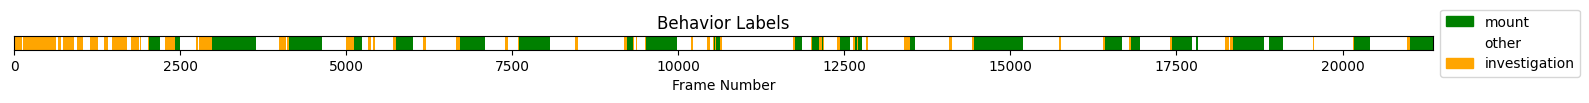

In [10]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)

plot_behavior_raster(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence)
    )

# Basic exploratory data analysis 🤓
Each Sequence has different amounts of each behavior, depending on what the mice do during the assay. Here, we get the percentage of frames of each behavior in each sequence. We can use this to split the training set into train and validation sets in a stratified way.

In [11]:
def get_percentage(sequence_key):
  anno_seq = num_to_text(training_data[sequence_key]['annotations'])
  counts = {k: np.mean(np.array(anno_seq) == k)*100.0 for k in vocab}
  return counts


anno_percentages = {k: get_percentage(k) for k in training_data}
anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df.head()

Percentage of frames in every sequence for every class


,attack,investigation,mount,other
task1/train/mouse001_task1_annotator1,0.000000,15.788242,30.251826,53.959933
task1/train/mouse002_task1_annotator1,9.067880,22.757587,0.000000,68.174533
task1/train/mouse003_task1_annotator1,0.000000,13.757374,13.167448,73.075178
task1/train/mouse004_task1_annotator1,0.000000,16.440199,7.735773,75.824028
task1/train/mouse005_task1_annotator1,7.516398,13.614607,0.000000,78.868995


## Percent of frames of each behavior in the full training set
Having looked at behavior distributions in a couple example Sequences, let's now look at the average over the entire training set.

In [12]:
all_annotations = []
for sk in training_data:
  anno = training_data[sk]['annotations']
  all_annotations.extend(list(anno))

all_annotations = num_to_text(all_annotations)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)*100.0})

,Behavior,Percentage Frames
0,attack,2.765009
1,investigation,28.876113
2,mount,5.635781
3,other,62.723097


# Split training data into train/validation sets
Because we don't want to overfit to our test set, we'll create a new validation set to test on while we're experimenting with our model.

We'll use the first cell to create some helper functions, and then implement the split in the following cell.

In [13]:
from sklearn.model_selection import train_test_split


def num_to_text(number_to_class, anno_list):
  """
  Convert list of class numbers to list of class names
  """
  return np.vectorize(number_to_class.get)(anno_list)


def split_validation(orig_pose_dictionary, vocabulary, seed=2021,
               test_size=0.5, split_videos=False):
  """
  Split data into train and validation sets:
  * Full sequences are either put into train or validation to avoid data leakage
  * By default, the "attack" behavior's presence is used to stratify the split
  * Optionally, the sequences may be split into half and treated as separate sequences
  """

  if test_size == 0.0:
    return orig_pose_dictionary, None

  number_to_class = {v: k for k, v in vocabulary.items()}
  if split_videos:
    pose_dictionary = {}
    for key in orig_pose_dictionary:
      key_pt1 = key + '_part1'
      key_pt2 = key + '_part2'
      anno_len = len(orig_pose_dictionary[key]['annotations'])
      split_idx = anno_len // 2
      pose_dictionary[key_pt1] = {
          'annotations': orig_pose_dictionary[key]['annotations'][:split_idx],
          'keypoints': orig_pose_dictionary[key]['keypoints'][:split_idx]}
      pose_dictionary[key_pt2] = {
          'annotations': orig_pose_dictionary[key]['annotations'][split_idx:],
          'keypoints': orig_pose_dictionary[key]['keypoints'][split_idx:]}
  else:
    pose_dictionary = orig_pose_dictionary

  def get_percentage(sequence_key):
    anno_seq = num_to_text(
        number_to_class, pose_dictionary[sequence_key]['annotations'])
    counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
    return counts

  anno_percentages = {k: get_percentage(k) for k in pose_dictionary}

  anno_perc_df = pd.DataFrame(anno_percentages).T

  rng_state = np.random.RandomState(seed)
  try:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                          stratify=anno_perc_df['attack'] > 0,
                                          test_size=test_size,
                                          random_state=rng_state)
  except:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                          test_size=test_size,
                                          random_state=rng_state)

  train_data = {k: pose_dictionary[k] for k in idx_train}
  val_data = {k: pose_dictionary[k] for k in idx_val}
  return train_data, val_data

In [14]:
train, val = split_validation(training_data, vocab, test_size=0.25)
print("Number of Sequences in train set: ", len(train))
print("Number of Sequences in validation set: ", len(val))

Number of Sequences in train set:  52
Number of Sequences in validation set:  18


# Preprocessing script

We might also want to normalize the data, based on the information that the frame size is 1024x570

The original data is of shape (sequence length, mouse, x y coordinate, keypoint)
 = (length, 2, 2, 7)

If `rotate==True`, this code also swaps the x y and the keypoint axis, to make rotation of the poses (eg to center on one of the mice) easier.

In [15]:
def normalize_data(orig_pose_dictionary, rotate=False):
  for key in orig_pose_dictionary:
    X = orig_pose_dictionary[key]['keypoints']
    if rotate:
      X = X.transpose((0, 1, 3, 2))  # last axis is x, y coordinates
      X[..., 0] = X[..., 0]/1024
      X[..., 1] = X[..., 1]/570
    else:
      X[:, :, 0, :] = X[:, :, 0, :] / 1024
      X[: ,:, 1, :] = X[:, :, 1, :] / 570
    orig_pose_dictionary[key]['keypoints'] = X
  return orig_pose_dictionary